<a href="https://colab.research.google.com/github/EmathVirtuallab/P1/blob/main/Copy_of_Complex_Systems_Lab_Pretrained_Folder_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two possible ways to create your dataset: (1) Make one with your own with your camera/phone or (2) Build one with Image Search (Google/Bing)

The idea is to have (at least) two categories for which you will train an inference model. You will then present data from your reserved validation set to evaluate your models ability to distinguish the two categories. For example, pick any living object like ants and then collect photos with and without ants in the pictures. You will then put these pictures on your google drive and run a classification model just like with flowers 102.

The more photos you collect the better your model will be. You must have at least 50 photographs for each of your two categories. (This should not take a long time.)

Note you must put around 20% of your images into the valid folder.

Example data folders here: https://drive.google.com/drive/folders/1Je_gRF8RnhszAAbQhw2IzqM2_7byPVtL?usp=sharing

Example Ideas:

Ex1 Camera: Ant finder Close up of ground/floor with ants in photo vs Close up photo with no ants

Ex2 Camera: Palm tree with coconuts vs Palm tree with dates (Both are all over FAU)

Ex3 Web Search: Marine animal (bird) vs Marine animal covered in oil from oil spill

Ex4 Web Search: Burrowing owl adult vs Burrowing owl chick

In [3]:
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26245 sha256=1881286f61085166e0b9755516c9dfeac410c446e571a9413b5caa2cccd29012
  Stored in directory: /root/.cache/pip/wheels/e8/bc/36/9ac3236719be1f1c6d1d758fc5e404410fe17027dd80d1d06d
Successfully built flashtorch


In [4]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix
from torchsummary import summary

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-hmignfhg
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-hmignfhg
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-py3-none-any.whl size=7429 sha256=d6e6861eafdf5d86b26a7ea73bbeaa8c7a168f5c7d7c507171096804af12c12a
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlj2zhme/wheels/81/51/4e/93fa1b6f290ba71f589593454d4d769f9baebd8c4c376822d9
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Create new folder on your google drive like below:

In [8]:
data_dir = '/content/drive/My Drive/i.Image/'

In [9]:
os.chdir(data_dir)

In [10]:
pwd

'/content/drive/My Drive/i.Image'

In [11]:
ls

train/  valid/


In [12]:
ls train

'green apple'/  'red apple'/


In [13]:
ls valid

'green apple'/  'red apple'/


In [14]:
dataset_labels =["green apple", "red apple"] #<--- Replace with your labels 

In [15]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [16]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
dataset_sizes

{'train': 206, 'valid': 208}

In [18]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

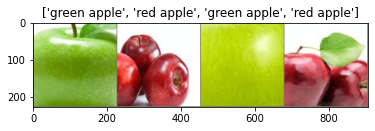

In [19]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [20]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [21]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [22]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
model.classifier[6] = nn.Linear(4096, 102)

In [25]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
model = train_model(model, num_epochs=3)

Epoch:  1 / 3
Train  Acc: 0.86
Valid  Acc: 1.00
#######################
Epoch:  2 / 3
Train  Acc: 0.98
Valid  Acc: 0.99
#######################
Epoch:  3 / 3
Train  Acc: 1.00
Valid  Acc: 1.00
#######################


In [27]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  2 / 30
Train  Acc: 0.99
Valid  Acc: 0.98
#######################
Epoch:  3 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  4 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  5 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  6 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  7 / 30
Train  Acc: 0.99
Valid  Acc: 1.00
#######################
Epoch:  8 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  9 / 30
Train  Acc: 0.99
Valid  Acc: 1.00
#######################
Epoch:  10 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  11 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  12 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  13 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  14 / 30
Train  Acc: 1.00
Valid  Acc: 1.

In [28]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

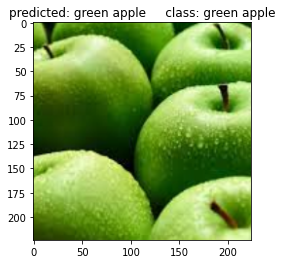

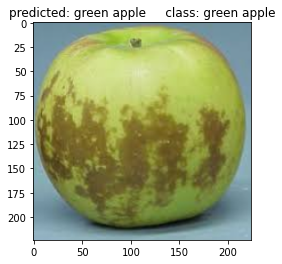

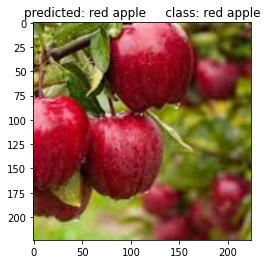

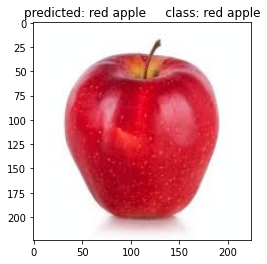

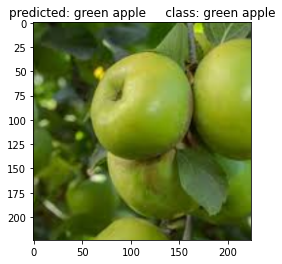

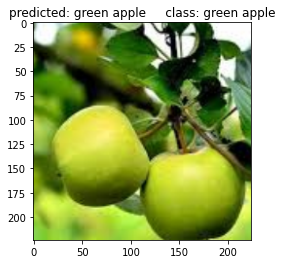

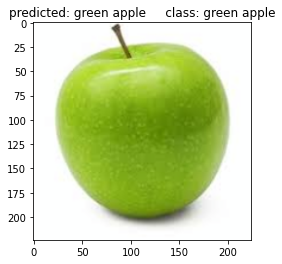

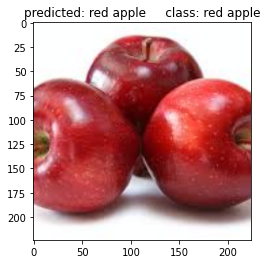

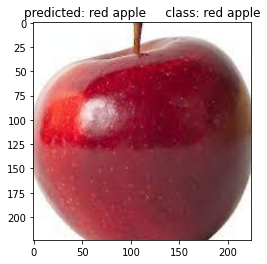

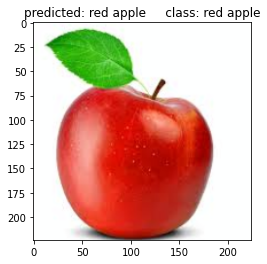

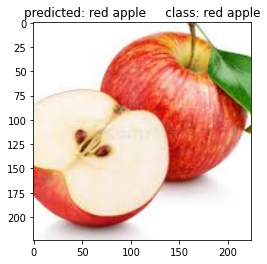

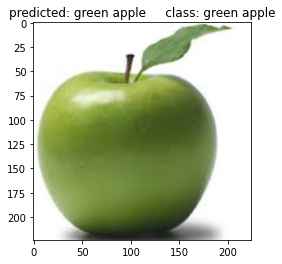

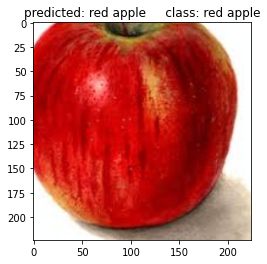

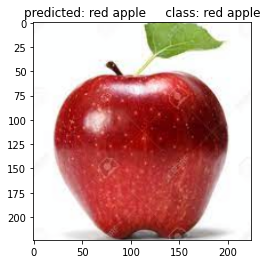

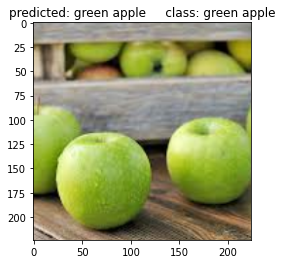

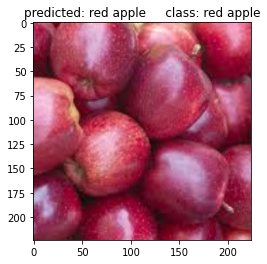

In [29]:
visualize_model(model)

In [30]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Test

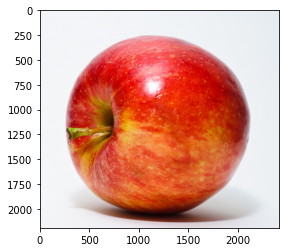

In [31]:
image = io.imread('https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg')
plt.imshow(image);

In [32]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [33]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [34]:
print('predicted: ' + dataset_labels[preds])

predicted: red apple


In [35]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [38]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [39]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[103,   0],
       [  0, 105]])